In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/My \Drive/Sem \8 \files/
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/Sem 8 files
 data   euclidean_distances.json  'Fri Feb 14 09_06_16 2020.json'


In [2]:
!apt-get install -y libspatialindex-c4v5
!pip3.6 install osmnx

import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import math

from shapely.geometry import box
from heapq import heappush, heappop
from itertools import count
from rtree import index

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 270 kB of archives.
After this operation, 1,107 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Fetched 270 kB in 1s (371 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 145118 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_amd64.deb ...
Unpacking libspatialindex4v5:amd64 (1.8.5-5) ...
Selecting previously unselected package libspatialindex-c4v5:amd64.
Preparing to u

In [3]:
place_name = "Singapore, Central, Singapore"
G = ox.save_load.load_graphml(filename="Singapore_processed.graphml")

# Stores nodes and edges mapped with speed bands along with other attributes
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [0]:
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
nodes = pd.read_pickle('data/nodes.pkl')

In [0]:
def process_speed_band(df):
    
    # Define Locations
    def truncate(number, digits) -> float:
        stepper = 10.0 ** digits
        return math.trunc(stepper * number) / stepper
    
    location = df['Location'].values
    i = 0
    
    for loc in location:
        x1, y1, x2, y2 = [float(n) for n in loc.split(' ')]
        
        x1 = truncate(x1, 7)
        y1 = truncate(y1, 7)
        x2 = truncate(x2, 7)
        y2 = truncate(y2, 7)
        
        if y1 < y2:
            bottom = y1
            top = y2
        else:
            bottom = y2
            top = y1
            
        if x1 < x2:
            left = x1
            right = x2
        else:
            left = x2
            right = x1
        
        df['Location'].values[i] = (left, bottom, right, top)
        i += 1 
    
    # Process maximum speeds
    i = 0
    for x in df['SpeedBand']:
        if x == 0:
            df['MaximumSpeed'][i] = '50'
        i += 1 

In [6]:
f = open("Fri Feb 14 09_06_16 2020.json", "r").read()
x = json.loads(f)

speed_bands = pd.DataFrame.from_dict(x, orient='columns')
process_speed_band(speed_bands)
# speed_bands.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
def calculate_congestion(G, edges, speed_bands):
    # Define Location    
    location = edges['geometry'].values
    i = 0
    Location = []
    
    for loc in location:        
        x1 = loc.xy[1][-1]
        y1 = loc.xy[0][-1]
        x2 = loc.xy[1][0]
        y2 = loc.xy[0][0]
        
        if y1 < y2:
            bottom = y1
            top = y2
        else:
            bottom = y2
            top = y1
            
        if x1 < x2:
            left = x1
            right = x2
        else:
            left = x2
            right = x1
        
        Location.append((left, bottom, right, top))
        i += 1 
        
    edges['Location'] = Location
    
    
    # Define observed_speed using speedband dataset 
    
    # key: maximum speed ,value: location
    idx = index.Index()
    Location = speed_bands['Location']
    Speed = speed_bands['MaximumSpeed'].astype(float)

    for speed, loc in zip(Speed, Location):
        idx.insert(int(speed), loc)
    
    # Find intersections
    observed_speed = []
    Location = edges['Location']

    for loc in Location:
        max_speeds = list(idx.intersection(loc))

        if len(max_speeds) == 0: # edge didn't intersect with any speed band
            observed_speed.append(70)
        else:
            observed_speed.append(sum(max_speeds)/len(max_speeds))  

    edges['observed_speed'] = observed_speed
    
    
    # Define BPR heuristic for each road link
    bpr = dict()
    n = len(edges['u'])

    for i in range (n):
        u = edges['u'][i]
        v = edges['v'][i]
        key = edges['key'][i]
        time = float(edges['travel_time'][i])
        flow = float(edges['observed_speed'][i])
        capacity = float(edges['maxspeed'][i])
        bpr[(u,v,key)] = time * (1 + 0.15*(flow/capacity)**4)
        
    nx.set_edge_attributes(G, bpr, 'BPR')

In [0]:
calculate_congestion(G, edges, speed_bands)
# edges.head()

### Finding shortest route between centroid of map and another point

In [9]:
# Boundary Box of entire area
bbox = box(*edges.unary_union.bounds)
orig_point = bbox.centroid
print(orig_point)

POINT (103.82129505 1.3515309)


In [10]:
target_point = nodes[nodes['osmid'] == 1820000257].geometry.values[0]
print(target_point)

POINT (103.9326163 1.3565805)


In [0]:
orig_xy = (orig_point.y, orig_point.x)
target_xy = (target_point.y, target_point.x)

In [0]:
# key: node label ,value: location
idx = index.Index()
xx = nodes['x'].astype(float)
yy = nodes['y'].astype(float)
node_label = nodes['osmid']

for node, x, y in zip(node_label, xx, yy):
    idx.insert(int(node), (x,y,x,y))

In [0]:
def find_nearest_nodes(source, dist, idx):
    # Create a bounding box around source of min distance in all directions
    (north, south, east, west) = ox.bbox_from_point(point=source, distance=dist)
    
    candidate_nodes = list(idx.intersection((west, south, east, north)))    
    return candidate_nodes

In [0]:
# Max distance for walking is 700m (10 min * 1.2 m/s)
# Find all nodes within 720 m from candidate sources and candidate destinations
candidate_dest = find_nearest_nodes(target_xy, 700, idx)
candidate_source = find_nearest_nodes(orig_xy, 700, idx)

In [0]:
def euclidean_distance(sources, destinations, nodes):
    distances = dict()
    
    for source in sources:
        x1 = nodes[nodes['osmid']==source]['x'].values[0]
        y1 = nodes[nodes['osmid']==source]['y'].values[0]
        
        for dest in destinations:
            x2 = nodes[nodes['osmid']==dest]['x'].values[0]
            y2 = nodes[nodes['osmid']==dest]['y'].values[0]
            
            # distance in metres, store it in sec
            d = 1000 * ((x1-x2)**2 + (y1-y2)**2)**0.5
            distances[(source,dest)] = d/5.28
    
    # sort the dictionary in ascending order using distances
    x = sorted(distances.items(), key = lambda kv:(kv[1], kv[0]))
    return x

In [0]:
x = euclidean_distance(candidate_source, candidate_dest, nodes)

In [0]:
def hybrid_routing(x, G):
    n = len(x)
    min_pair = x[0]
    source = min_pair[0][0]
    dest = min_pair[0][1]
    min_tt = float('inf')
    final_route = dict()

    for i in range(n):
      G.add_node(source, demand = -1)
      G.add_node(dest, demand = 1)
      travel_time, flowDict = nx.capacity_scaling(G, weight='BPR')
      G.add_node(source, demand = 0)
      G.add_node(dest, demand = 0)
      print(source, dest, travel_time)

      if travel_time < min_tt:
          min_tt = travel_time
          min_pair = x[i]
          final_route = flowDict

          if i < n-1:
              if travel_time < x[i+1][1]:
                  break
              else:
                  source = x[i+1][0][0]
                  dest = x[i+1][0][1]
          else:
              break
      else:
          break
    
    return final_route, min_tt, min_pair

In [19]:
final_dict, travel_cost, sd_pair = hybrid_routing(x, G)

4486815538 1819975126 3153.541456580273
1318459153 1819975126 3144.2880933955053
4486815537 1819975126 3148.954042562657


In [20]:
print(travel_cost/60)

52.40480155659176


In [0]:
def find_route(flow_dict, s ,t):
    route = []
    u = s #current node
    
    while(u != t):  
        flag=0
        for v,x in flow_dict[u].items():
            for k,f in x.items():
                if f > 0:
                    route.append([u,v,k])
                    u = v
                    flag = 1
                    break
            if flag == 1:
                break
    
    return route

In [0]:
edged_route = find_route(final_dict, sd_pair[0][0], sd_pair[0][1])

In [0]:
def plot_route(route, G, origin, destination):
    final_route = []
    
    for node in route:
        final_route.append(node[0])        
    final_route.append(route[-1][1])
    
    fig, ax = ox.plot_graph_route(G, final_route, origin_point=origin, destination_point=destination)
    plt.tight_layout()

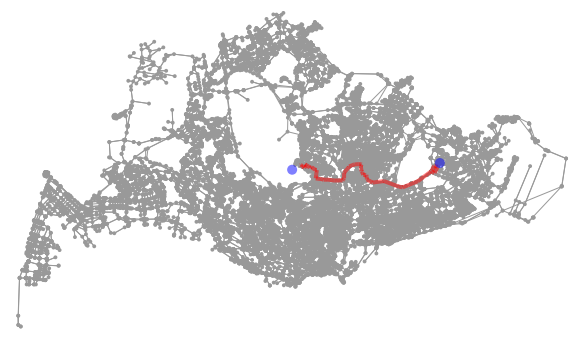

<Figure size 432x288 with 0 Axes>

In [24]:
plot_route(edged_route, G, orig_xy, target_xy)